In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.utils import from_scipy_sparse_matrix
from scipy.sparse import csr_matrix


In [3]:
# Load the dataset
file_path = 'IoT Network Intrusion Dataset.csv'  # Replace with your file path
data = pd.read_csv(file_path)
# Display the first few rows
print(data.head())

# Display summary statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())


                                     Flow_ID           Src_IP  Src_Port  \
0   192.168.0.13-192.168.0.16-10000-10101-17     192.168.0.13     10000   
1    192.168.0.13-222.160.179.132-554-2179-6  222.160.179.132      2179   
2     192.168.0.13-192.168.0.16-9020-52727-6     192.168.0.16     52727   
3     192.168.0.13-192.168.0.16-9020-52964-6     192.168.0.16     52964   
4  192.168.0.1-239.255.255.250-36763-1900-17      192.168.0.1     36763   

            Dst_IP  Dst_Port  Protocol               Timestamp  Flow_Duration  \
0     192.168.0.16     10101        17  25/07/2019 03:25:53 AM             75   
1     192.168.0.13       554         6  26/05/2019 10:11:06 PM           5310   
2     192.168.0.13      9020         6  11/07/2019 01:24:48 AM            141   
3     192.168.0.13      9020         6  04/09/2019 03:58:17 AM            151   
4  239.255.255.250      1900        17  10/09/2019 01:41:18 AM            153   

   Tot_Fwd_Pkts  Tot_Bwd_Pkts  ...  Active_Std  Active_Max  Ac

c:\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


            Src_Port       Dst_Port       Protocol  Flow_Duration  \
count  625783.000000  625783.000000  625783.000000  625783.000000   
mean    35026.156190   16387.027479       9.971436     635.422865   
std     24721.047752   17550.363037       5.379857    3496.740723   
min         0.000000       0.000000       0.000000       0.000000   
25%      9020.000000    8899.000000       6.000000      76.000000   
50%     51991.000000    9020.000000       6.000000     132.000000   
75%     56361.000000   10101.000000      17.000000     221.000000   
max     65500.000000   65371.000000      17.000000   99984.000000   

        Tot_Fwd_Pkts  Tot_Bwd_Pkts  TotLen_Fwd_Pkts  TotLen_Bwd_Pkts  \
count  625783.000000  625783.00000    625783.000000    625783.000000   
mean        1.675566       1.46853       570.738980       929.280973   
std         4.309970       1.21949      1161.873195      1731.760875   
min         0.000000       1.00000         0.000000         0.000000   
25%         0.0000

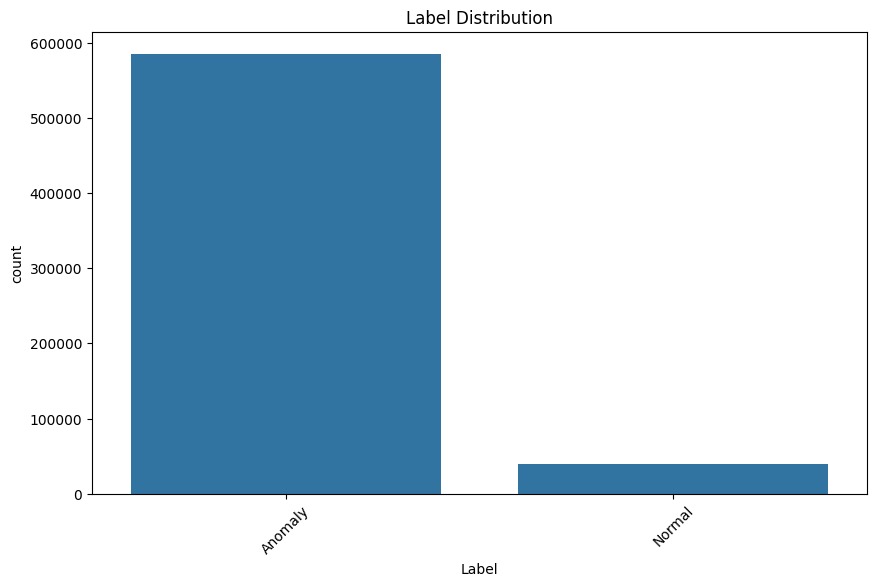

In [4]:
# Replace infinite values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
data.dropna(inplace=True)

# Label Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=data)
plt.title('Label Distribution')
plt.xticks(rotation=45)
plt.show()

# Encode the target variable
data['Label'] = data['Label'].astype('category').cat.codes


In [5]:
# Separate features and target variable
X = data.drop(columns=['Label'])
y = data['Label']

# Exclude non-numeric columns from X
numeric_columns = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=20)  # You can adjust the number of components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [6]:
# Print the PCA components and the explained variance ratio
print("PCA Components:")
print(pca.components_)
print("\nExplained Variance Ratio:")
print(pca.explained_variance_ratio_)

# Display the principal components with their corresponding original features
pca_components_df = pd.DataFrame(pca.components_, columns=X_numeric.columns)
print("\nPrincipal Components with Original Features:")
print(pca_components_df)


PCA Components:
[[-0.03504519  0.10690059 -0.02092542 ... -0.10710506 -0.17760201
  -0.14742915]
 [-0.11716211  0.07320619 -0.09114278 ...  0.17859451  0.21422123
   0.11778776]
 [-0.0093628  -0.06158389 -0.21588986 ... -0.07523995 -0.03961687
   0.02704105]
 ...
 [-0.14315538  0.10701805  0.04210771 ...  0.01203979 -0.00664852
  -0.01983309]
 [ 0.24303824 -0.1754954  -0.05139842 ... -0.06325169  0.02093937
   0.08169223]
 [ 0.12418239  0.08512055  0.08211875 ... -0.23342515  0.02971561
   0.23778477]]

Explained Variance Ratio:
[0.19697959 0.16220333 0.09246106 0.07279035 0.04994388 0.04367711
 0.0406545  0.03414289 0.03331342 0.02907264 0.02479906 0.02424852
 0.01934496 0.0162625  0.01609248 0.0144532  0.01411602 0.01376316
 0.01346256 0.01174734]

Principal Components with Original Features:
    Src_Port  Dst_Port  Protocol  Flow_Duration  Tot_Fwd_Pkts  Tot_Bwd_Pkts  \
0  -0.035045  0.106901 -0.020925      -0.167740     -0.023765     -0.052664   
1  -0.117162  0.073206 -0.091143    

In [7]:
# Convert the data to a PyTorch Geometric Data object
def create_data_object(X, y):
    edge_index = csr_matrix((X.shape[0], X.shape[0]))  # Placeholder for fully connected graph
    edge_index = from_scipy_sparse_matrix(edge_index)[0]
    
    x = torch.tensor(X, dtype=torch.float)
    y = torch.tensor(y.to_numpy(), dtype=torch.long)  # Convert Series to numpy array
    
    data = Data(x=x, edge_index=edge_index, y=y)
    return data

data_list = [create_data_object(X_train_pca, y_train), create_data_object(X_test_pca, y_test)]


In [8]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GIN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(input_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Linear(hidden_dim, hidden_dim))
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Linear(hidden_dim, output_dim))
        self.conv1 = GINConv(nn1)
        self.conv2 = GINConv(nn2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [9]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mask):
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int((pred[mask] == data.y[mask]).sum())
    mask_sum = int(mask.sum())
    acc = correct / mask_sum if mask_sum != 0 else 0
    return acc

# Split masks
data_list[0].train_mask = torch.ones(data_list[0].num_nodes, dtype=torch.bool)
data_list[0].test_mask = torch.zeros(data_list[0].num_nodes, dtype=torch.bool)
data_list[1].train_mask = torch.zeros(data_list[1].num_nodes, dtype=torch.bool)
data_list[1].test_mask = torch.ones(data_list[1].num_nodes, dtype=torch.bool)

# Model training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models, optimizers and loss function
input_dim = X_train_pca.shape[1]
hidden_dim = 64
output_dim = len(np.unique(y_train))

models = {
    'GCN': GCN(input_dim, hidden_dim, output_dim).to(device),
    'GIN': GIN(input_dim, hidden_dim, output_dim).to(device)
}

performance_metrics = {model_name: {'train_loss': [], 'train_acc': [], 'test_acc': []} for model_name in models}

criterion = torch.nn.CrossEntropyLoss()

for model_name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    train_data = data_list[0].to(device)
    test_data = data_list[1].to(device)
    
    for epoch in range(101):
        loss = train(model, train_data, optimizer, criterion)
        if epoch % 10 == 0:
            train_acc = evaluate(model, train_data, train_data.train_mask)
            test_acc = evaluate(model, test_data, test_data.test_mask)
            print(f'{model_name} - Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
            
            # Store performance metrics
            performance_metrics[model_name]['train_loss'].append(loss)
            performance_metrics[model_name]['train_acc'].append(train_acc)
            performance_metrics[model_name]['test_acc'].append(test_acc)
    
    test_acc = evaluate(model, test_data, test_data.test_mask)


GCN - Epoch: 0, Loss: 0.6232, Train Acc: 0.9386, Test Acc: 0.9379
GCN - Epoch: 10, Loss: 0.1437, Train Acc: 0.9391, Test Acc: 0.9385
GCN - Epoch: 20, Loss: 0.1287, Train Acc: 0.9557, Test Acc: 0.9553
GCN - Epoch: 30, Loss: 0.1183, Train Acc: 0.9547, Test Acc: 0.9540
GCN - Epoch: 40, Loss: 0.1116, Train Acc: 0.9576, Test Acc: 0.9566
GCN - Epoch: 50, Loss: 0.1062, Train Acc: 0.9618, Test Acc: 0.9610
GCN - Epoch: 60, Loss: 0.1015, Train Acc: 0.9654, Test Acc: 0.9646
GCN - Epoch: 70, Loss: 0.0973, Train Acc: 0.9658, Test Acc: 0.9651
GCN - Epoch: 80, Loss: 0.0934, Train Acc: 0.9684, Test Acc: 0.9675
GCN - Epoch: 90, Loss: 0.0897, Train Acc: 0.9706, Test Acc: 0.9697
GCN - Epoch: 100, Loss: 0.0863, Train Acc: 0.9720, Test Acc: 0.9712
GIN - Epoch: 0, Loss: 0.7208, Train Acc: 0.9362, Test Acc: 0.9353
GIN - Epoch: 10, Loss: 0.1692, Train Acc: 0.9362, Test Acc: 0.9353
GIN - Epoch: 20, Loss: 0.1384, Train Acc: 0.9363, Test Acc: 0.9354
GIN - Epoch: 30, Loss: 0.1273, Train Acc: 0.9530, Test Acc: 0.9

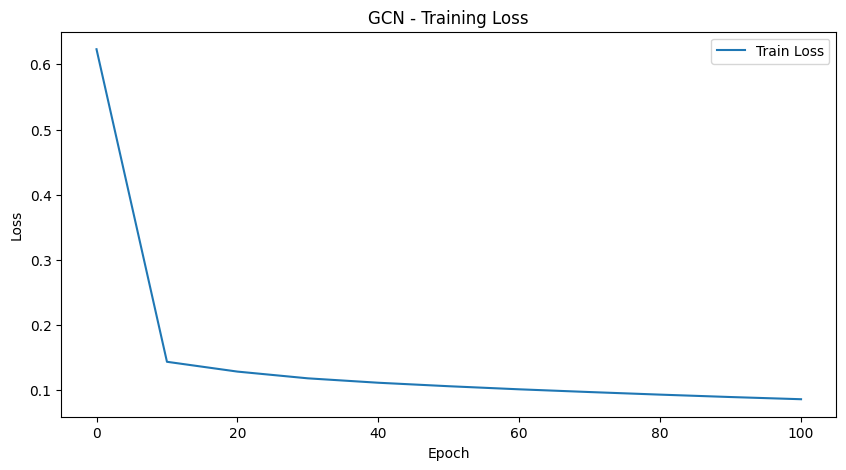

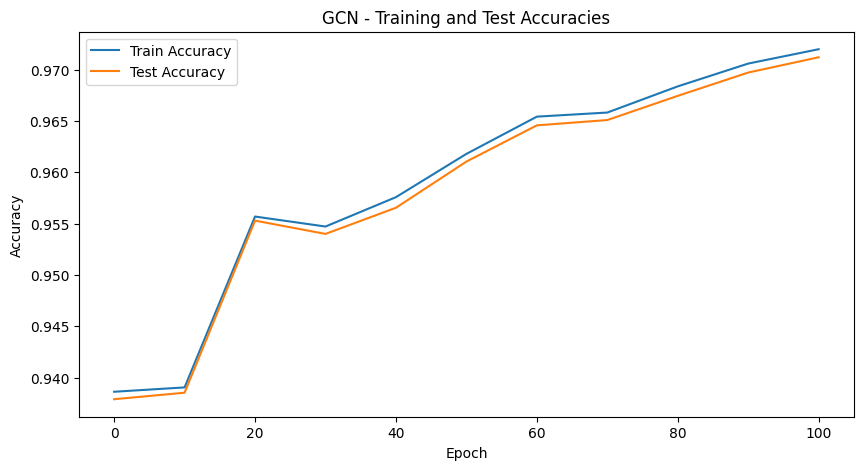

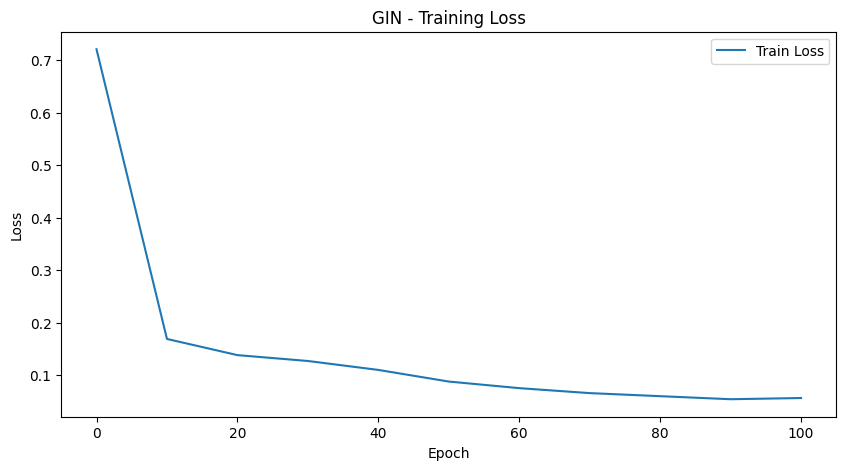

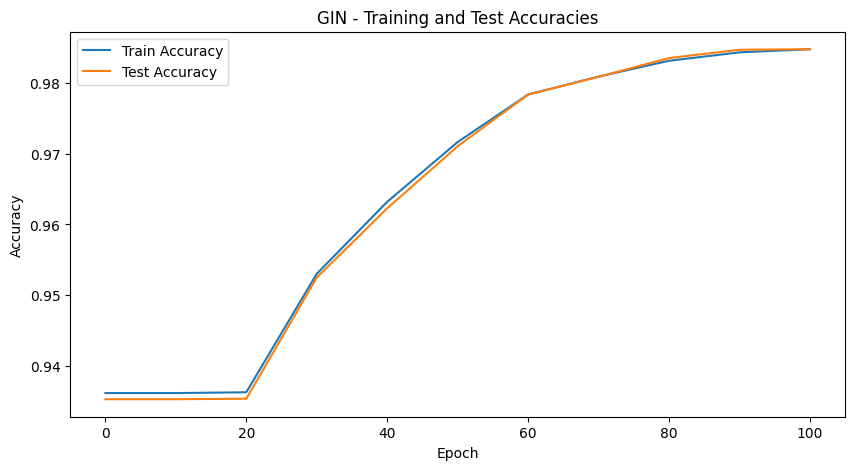

In [10]:
def plot_metrics(train_losses, train_accuracies, test_accuracies, model_name):
    epochs = range(0, 101, 10)
    
    # Plot Losses
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training Loss')
    plt.legend()
    plt.show()
    
    # Plot Accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Training and Test Accuracies')
    plt.legend()
    plt.show()

# Plotting
for model_name, metrics in performance_metrics.items():
    train_losses = metrics['train_loss']
    train_accuracies = metrics['train_acc']
    test_accuracies = metrics['test_acc']
    plot_metrics(train_losses, train_accuracies, test_accuracies, model_name)
